# Time Series Machine Learning Regression Framework
by Pourya Ayria APR 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

import warnings
warnings.filterwarnings('ignore')

# Data Prepration
We drop Normalised vlaues of weekly data: Normalised 0, Normalised 1, ..., Normalised 51 columns.
Data can be found at https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly

In [2]:
df_org = pd.read_csv('./data/Sales_Transactions_Dataset_Weekly.csv')
df_org = df_org.filter(regex=r'Product|W')
df_org.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [3]:
df = df_org.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

df['Product_Code'] = df['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
df['Week'] = df['Week'].str.extract('(\d+)', expand=False).astype(int)

df = df.sort_values(['Week', 'Product_Code'])
df.head(10)

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
5,6,0,3
6,7,0,4
7,8,0,8
8,9,0,14
9,10,0,22


In [4]:
df.tail(10)

,Product_Code,Week,Sales
42162,810,51,1
42163,811,51,5
42164,812,51,4
42165,813,51,4
42166,814,51,11
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0
42171,819,51,1


# To Supervised

In [5]:
class ToSupervised(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        
            
        return tmp

In [6]:
class ToSupervisedDiff(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago_Diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

# Time Series K-Fold

In [7]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init,self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)
        

# Metric: RMSLE 

In [8]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Baseline Estimator

In [9]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error 

# Time Series Regression

In [10]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [11]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors


# Steps Tuning

In [12]:
def getDataFramePipeline(i):
    steps = [(str(i)+'_step',ToSupervised('Sales','Product_Code',i))]
    for j in range(1,i+1):
        if i==j:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1,dropna=True))
            steps.append(pp)
        else:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1))
            steps.append(pp)
            
    return steps
            

In [13]:
from tqdm import tqdm
def stepsTune(X,model,num_steps,init=1):
    scores = []
    for i in tqdm(range(init,num_steps+1)):
        steps = []
        steps.extend(getDataFramePipeline(i))
        steps.append(('predic_1',model))
        super_ = Pipeline(steps).fit(X)
        score_ = np.mean(super_.score(X))
        scores.append((i,score_))
        
    return scores

# Tune Hyperparameters

In [14]:
from collections.abc import Mapping, Sequence, Iterable
from itertools import product
from functools import partial, reduce
import operator

class TimeGridBasic(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,param_grid):
        
    
        if not isinstance(param_grid, (Mapping, Iterable)):
                raise TypeError('Parameter grid is not a dict or '
                                'a list ({!r})'.format(param_grid))

        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]


        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]

        # check if all entries are dictionaries of lists
        for grid in param_grid:
            if not isinstance(grid, dict):
                raise TypeError('Parameter grid is not a '
                                'dict ({!r})'.format(grid))
            for key in grid:
                if not isinstance(grid[key], Iterable):
                    raise TypeError('Parameter grid value is not iterable '
                                    '(key={!r}, value={!r})'
                                    .format(key, grid[key]))


        self.param_grid = param_grid
                
    def __iter__(self):
        """Iterate over the points in the grid.
        Returns
        -------
        params : iterator over dict of string to any
            Yields dictionaries mapping each estimator parameter to one of its
            allowed values.
        """
        for p in self.param_grid:
            # Always sort the keys of a dictionary, for reproducibility
            items = sorted(p.items())
            if not items:
                yield {}
            else:
                keys, values = zip(*items)
                for v in product(*values):
                    params = dict(zip(keys, v))
                    yield params   

In [15]:
class TimeSeriesGridSearch(TimeGridBasic,base.BaseEstimator, base.RegressorMixin):
    
    
    def __init__(self,**options):
        
        self.model      = options.pop('model', None)
        self.cv         = options.pop('cv', None)
        self.verbosity  = options.pop('verbosity', False)
        self.scoring    = options.pop('scoring', None)
        param_grid      = options.pop('param_grid', None)
        self.param_grid = TimeGridBasic(param_grid)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))

        if ((self.model==None )| (self.cv==None)):
            raise TypeError("Incomplete inputs")
            
            
    def fit(self,X,y=None):
        self.X = X
        return self


    def _get_score(self,param):

        errors = []
        for indx,fold in enumerate(self.cv.split(self.X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.set_params(**param).fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))
                
        
        return errors

    def score(self):

        errors=[]
        get_param = []
        for param in self.param_grid:
            
            if self.verbosity:
                print(param)
                
            errors.append(np.mean(self._get_score(param)))
            get_param.append(param)

        self.sorted_errors,self.sorted_params = (list(t) for t in zip(*sorted(zip(errors,get_param))))
        
        return self.sorted_errors,self.sorted_params
    
    
    def best_estimator(self,verbosity=False):

        if verbosity:
            print('error: {:.4f} \n'.format(self.sorted_errors[0]))
            print('Best params:')
            print(self.sorted_params[0])

        return self.sorted_params[0]




# Sales Distribution 

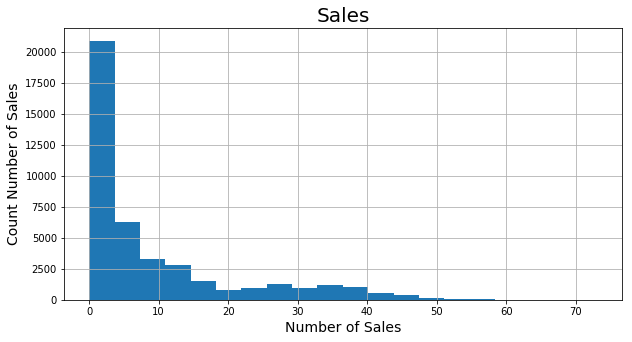

In [16]:
df['Sales'].hist(bins=20, figsize=(10,5))
plt.xlabel('Number of Sales',fontsize=14)
plt.ylabel('Count Number of Sales',fontsize=14)
plt.title('Sales',fontsize=20)
plt.show()

# Data Prepration

In [17]:
steps = [('1_step',ToSupervised('Sales','Product_Code',1)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(df)

In [18]:
super_1.head()

,Product_Code,Week,Sales,1_Week_Ago_Sales,1_Week_Ago_Diff__1_Week_Ago_Sales
0,1,2,10,12.0,1.0
1,2,2,3,6.0,-1.0
2,3,2,8,11.0,4.0
3,4,2,13,8.0,-4.0
4,5,2,13,5.0,-3.0


# Base Model

In [19]:
kf = Kfold_time(target='Sales',date_col = 'Week',date_init=40,date_final=52)

In [20]:
base_model = BaseEstimator('1_Week_Ago_Sales')
errors = []
for indx,fold in enumerate(kf.split(super_1)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

Fold: 0, Error: 0.520
Fold: 1, Error: 0.517
Fold: 2, Error: 0.510
Fold: 3, Error: 0.508
Fold: 4, Error: 0.534
Fold: 5, Error: 0.523
Fold: 6, Error: 0.500
Fold: 7, Error: 0.491
Fold: 8, Error: 0.506
Fold: 9, Error: 0.505
Fold: 10, Error: 0.522
Fold: 11, Error: 0.552
Total Error 0.516


# First Model - One Step

In [21]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [22]:
steps_1 = [('1_step',ToSupervised('Sales','Product_Code',1)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_1',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_1_p = Pipeline(steps_1).fit(df)

In [23]:
Model_1_Error = super_1_p.score(df)

Fold: 0, Error: 0.4624
Fold: 1, Error: 0.4596
Fold: 2, Error: 0.4617
Fold: 3, Error: 0.4666
Fold: 4, Error: 0.4712
Fold: 5, Error: 0.4310
Fold: 6, Error: 0.4718
Fold: 7, Error: 0.4494
Fold: 8, Error: 0.4608
Fold: 9, Error: 0.4470
Fold: 10, Error: 0.4746
Fold: 11, Error: 0.4865
Total Error 0.4619


# Second Model - Four Steps

In [24]:
steps_3 = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_3_p = Pipeline(steps_3).fit(df)

In [25]:
Model_3_Error = super_3_p.score(df)

Fold: 0, Error: 0.4312
Fold: 1, Error: 0.4385
Fold: 2, Error: 0.4274
Fold: 3, Error: 0.4194
Fold: 4, Error: 0.4479
Fold: 5, Error: 0.4070
Fold: 6, Error: 0.4395
Fold: 7, Error: 0.4333
Fold: 8, Error: 0.4387
Fold: 9, Error: 0.4305
Fold: 10, Error: 0.4591
Fold: 11, Error: 0.4534
Total Error 0.4355


# Change the Target Distribution

In [26]:
steps_3_log = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmsle))]
super_3_p_log = Pipeline(steps_3_log).fit(df)

In [27]:
Model_3_Log_Error = super_3_p_log.score(df)

Fold: 0, Error: 0.4168
Fold: 1, Error: 0.4221
Fold: 2, Error: 0.4125
Fold: 3, Error: 0.4035
Fold: 4, Error: 0.4332
Fold: 5, Error: 0.3977
Fold: 6, Error: 0.4263
Fold: 7, Error: 0.4122
Fold: 8, Error: 0.4301
Fold: 9, Error: 0.4375
Fold: 10, Error: 0.4462
Fold: 11, Error: 0.4727
Total Error 0.4259


# LightGBM Model

In [28]:
model_lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
steps_3_log_lgbm = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model_lgb ,cv=kf,scoring=rmsle))]
super_3_p_log_lgbm = Pipeline(steps_3_log_lgbm).fit(df)

In [29]:
Model_3_Log_Error = super_3_p_log_lgbm.score(df)

Fold: 0, Error: 0.4081
Fold: 1, Error: 0.3980
Fold: 2, Error: 0.3953
Fold: 3, Error: 0.3949
Fold: 4, Error: 0.4202
Fold: 5, Error: 0.3768
Fold: 6, Error: 0.4039
Fold: 7, Error: 0.3868
Fold: 8, Error: 0.3984
Fold: 9, Error: 0.4075
Fold: 10, Error: 0.4209
Fold: 11, Error: 0.4520
Total Error 0.4052


# Tuning Number of Steps

In [30]:
model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
list_scores2 = stepsTune(df,
                         TimeSeriesRegressorLog(model=model_lgbm,scoring=rmsle,
                                             cv=kf,verbosity=False),20)


100%|██████████| 20/20 [05:51<00:00, 20.17s/it]


Text(0.5,1,'Steps Tuning')

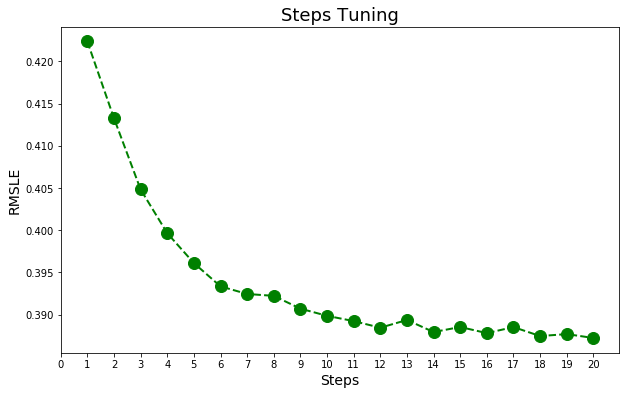

In [31]:
plt.figure(figsize=(10,6))
x = [i[0] for i in list_scores2]
y = [i[1] for i in list_scores2]
plt.plot(x,y,color='green', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(0, 21, step=1))
plt.xlabel('Steps',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Steps Tuning',fontsize=18)

# Tune Hyperparameters

In [32]:
params = {'n_estimators':[100,500,1000,1500,2000],
         'learning_rate':[0.005,.01,.1]}

steps_20 = getDataFramePipeline(20)
super_20 = Pipeline(steps_20).fit_transform(df)


model_lgbm2 = LGBMRegressor(random_state=0)
tune_lgbm =TimeSeriesGridSearch(model = model_lgbm2, cv = kf,param_grid=params,verbosity=False,scoring=rmsle)

In [33]:
tt = tune_lgbm.fit(super_20).score()

# Prediction vs. Real Sales

In [34]:
kf_51 = Kfold_time(target='Sales',date_col = 'Week',date_init=51,date_final=52)

In [35]:
best_param = tune_lgbm.best_estimator()
model_lgbmf = LGBMRegressor(**best_param,random_state=0)

T_51 = TimeSeriesRegressorLog(model=model_lgbmf ,scoring=rmsle,
                                             cv=kf_51,verbosity=False)
T_51.fit(super_20)
prediction_51 =T_51.predict(super_20)

In [36]:
prediction_51.head()

,0_fold
0,9.141751
1,4.073397
2,8.553865
3,8.546964
4,8.476343


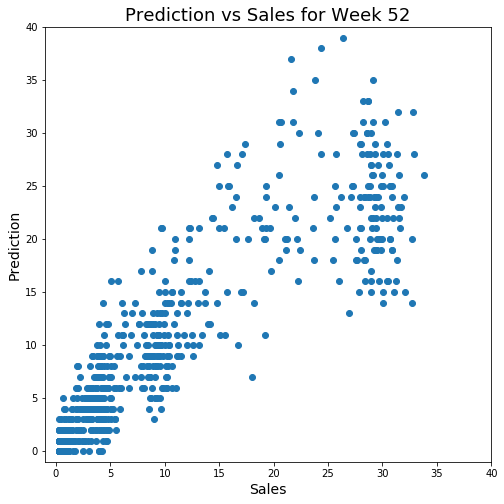

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(prediction_51['0_fold'],df[df['Week']==51]['Sales'])
plt.xlabel('Sales',fontsize=14)
plt.ylabel('Prediction',fontsize=14)
plt.xlim((-1,40))
plt.ylim((-1,40))
plt.title('Prediction vs Sales for Week 52',fontsize=18)
plt.show()

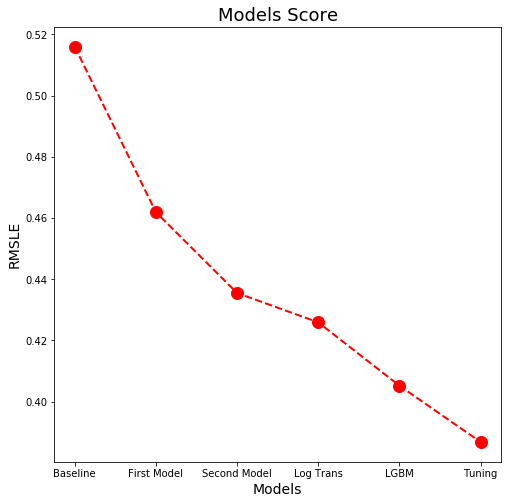

In [38]:
models=['Baseline','First Model','Second Model','Log Trans','LGBM','Tuning']
models_erros = [0.516,0.4619,0.4355,0.4259,0.4052,0.3868]
plt.figure(figsize=(8,8))
plt.plot(np.arange(6),models_erros,color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(6), models)
plt.xlabel('Models',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Models Score',fontsize=18)
plt.show()

In [39]:
print('Error reduce: ',(0.516 - 0.3868)/0.516*100)

Error reduce:  25.038759689922486
